## Importing necessary packages

In [1]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Defining necessary constants

In [2]:
dataset_path = "../data/AEP_hourly.csv"

## Preparing the dataset

In [3]:
dataset = pd.read_csv(dataset_path)
dataset.drop_duplicates(subset=["Datetime"], inplace=True)

mask = dataset["Datetime"] > "2016-12-31"
dataset = dataset[mask]

dataset

,Datetime,AEP_MW
98594,2016-12-31 01:00:00,14877.0
98595,2016-12-31 02:00:00,14588.0
98596,2016-12-31 03:00:00,14514.0
98597,2016-12-31 04:00:00,14591.0
98598,2016-12-31 05:00:00,14604.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [4]:
# Dividing the energy values by 10^7 to simulate the individual hourly energy consumption

dataset["AEP_MW"] /= 10 ** 4
dataset.rename(columns={"AEP_MW": "Consumption_KWh"}, inplace=True)
dataset["Datetime"] = pd.to_datetime(dataset["Datetime"])
dataset

,Datetime,Consumption_KWh
98594,2016-12-31 01:00:00,1.4877
98595,2016-12-31 02:00:00,1.4588
98596,2016-12-31 03:00:00,1.4514
98597,2016-12-31 04:00:00,1.4591
98598,2016-12-31 05:00:00,1.4604
...,...,...
121268,2018-01-01 20:00:00,2.1089
121269,2018-01-01 21:00:00,2.0999
121270,2018-01-01 22:00:00,2.0820
121271,2018-01-01 23:00:00,2.0415


In [5]:
# There are no missing values

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13919 entries, 98594 to 121272
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datetime         13919 non-null  datetime64[ns]
 1   Consumption_KWh  13919 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 326.2 KB


In [6]:
dataset.describe()

,Consumption_KWh
count,13919.000000
mean,1.478261
std,0.240189
min,0.969800
25%,1.307450
50%,1.450600
75%,1.625250
max,2.275900


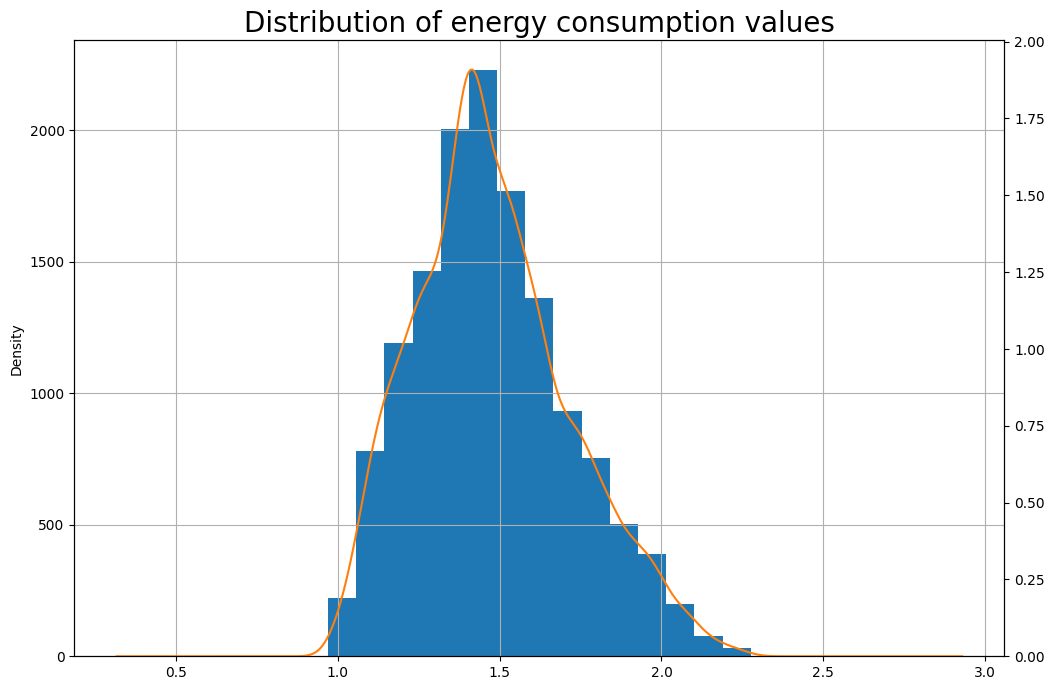

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
dataset["Consumption_KWh"].hist(ax=ax, bins=15)
ax2 = dataset["Consumption_KWh"].plot.kde(ax=ax, secondary_y=True)
ax2.set_ylim(0)
plt.title("Distribution of energy consumption values", fontsize=20)
plt.show()

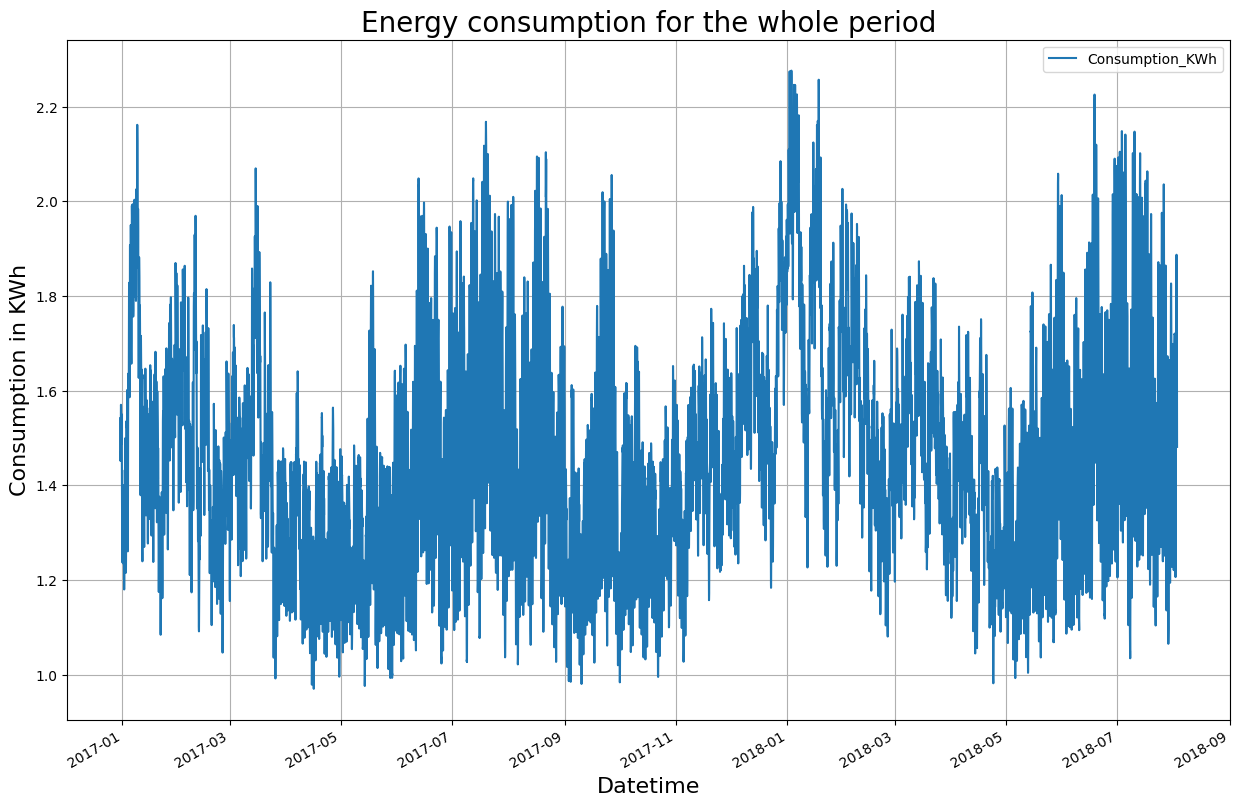

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
dataset.set_index("Datetime").plot(ax=ax)
plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Consumption in KWh", fontsize=16)
plt.title("Energy consumption for the whole period", fontsize=20)
plt.grid()
plt.show()

In [9]:
# Splitting the data

train_mask = dataset["Datetime"] < "2018-05-01"

train_data = dataset.loc[train_mask].sort_values("Datetime").set_index("Datetime")
test_data  = dataset.loc[~train_mask].sort_values("Datetime").set_index("Datetime")

print("Size of the training data:", len(train_data))
print("Size of the testing data: ", len(test_data))

Size of the training data: 11662
Size of the testing data:  2257


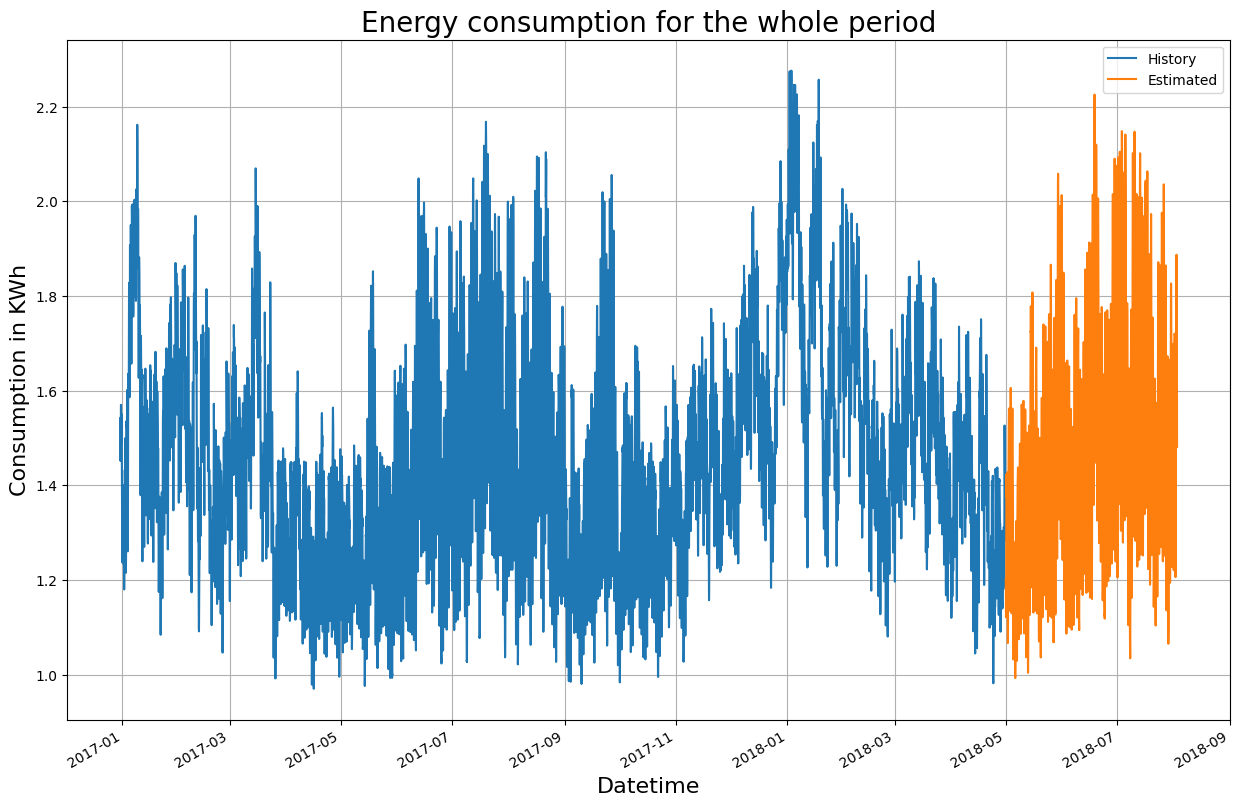

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
train_data["Consumption_KWh"].plot(ax=ax, label="History")
test_data["Consumption_KWh"].plot(ax=ax, label="Estimated")
plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Consumption in KWh", fontsize=16)
plt.title("Energy consumption for the whole period", fontsize=20)
plt.legend()
plt.grid()
plt.show()

## Training the algorithm

In [23]:
lags = 3000
model = AutoReg(train_data, lags=lags, trend='n')
model = model.fit()

/home/faranio/Desktop/EDISS/Courses/2nd Year. Semester 1/Software Architectures/Final Project/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Evaluating the algorithm

/home/faranio/Desktop/EDISS/Courses/2nd Year. Semester 1/Software Architectures/Final Project/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/faranio/Desktop/EDISS/Courses/2nd Year. Semester 1/Software Architectures/Final Project/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<AxesSubplot: xlabel='Datetime'>

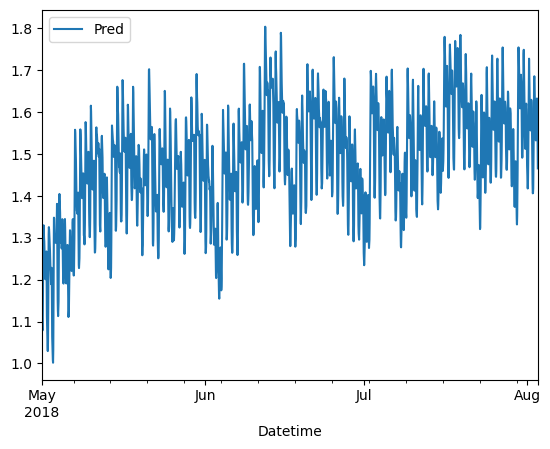

In [24]:
y_pred = model.predict(start=len(train_data)+1, end=len(train_data) + len(test_data))
y_pred = y_pred.to_frame()
y_pred.index = test_data.index
y_pred.columns = ["Pred"]
y_pred.plot()

In [25]:
error = np.sqrt(mean_squared_error(test_data["Consumption_KWh"].values, y_pred))

print("Best RMSE:    0.2544569509340578")
print("Current RMSE:", error)

print("Best lags:    3000")
print("Current lags:", lags)

Best RMSE:    0.2544569509340578
Current RMSE: 0.2544569509340578
Best lags:    3000
Current lags: 3000


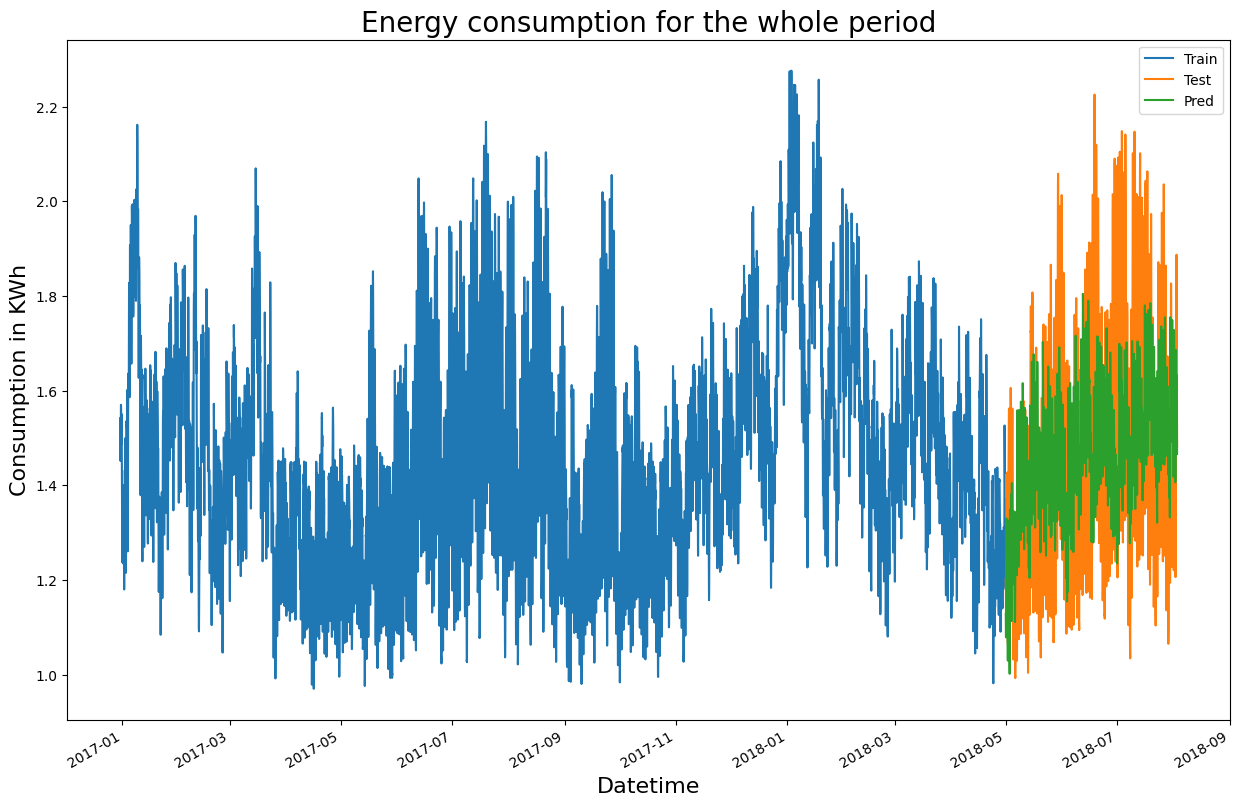

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
train_data["Consumption_KWh"].plot(ax=ax, label="Train")
test_data["Consumption_KWh"].plot(ax=ax, label="Test")
y_pred.plot(ax=ax, label="Prediction")
plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Consumption in KWh", fontsize=16)
plt.title("Energy consumption for the whole period", fontsize=20)
plt.legend()
plt.show()

In [27]:
model.save("best_model.pkl")